# Pixel classification on OpenCL-compatible GPUs
APOC is based on [pyclesperanto](https://github.com/clEsperanto/pyclesperanto_prototype) and [sklearn](https://scikit-learn.org/stable/).

Often, we want to include information from multiple channels (i.e., from different stainings) to be included in the prediction. APOC allows you to do just that. Let's start with loading an example image and some ground truth:

<NVIDIA GeForce MX230 on Platform: NVIDIA CUDA (1 refs)>

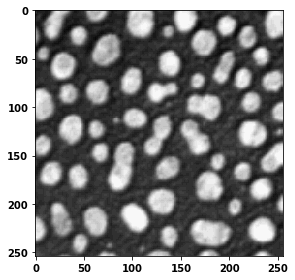

In [1]:
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
import numpy as np
import apoc

image = imread('blobs.tif')
imshow(image)

You can now create some annotations.

*Note*: Even though your data may be multichannel data, annotations do not have to be multichannel. E.g., for a `[2, 256, 256]`-shaped image, creating an (scarcely) annotated image of shape `[256, 256]` works for APOC.

In [2]:
if False: # you can use this to make manual annotations
    import napari

    # start napari
    viewer = napari.Viewer()
    napari.run()

    # add image
    viewer.add_image(image)

    # add an empty labels layer and keep it in a variable
    labels = np.zeros(image.shape).astype(int)
    viewer.add_labels(labels)
else:
    labels = imread('annotations.tif')

C:\Users\johan\anaconda3\envs\apoc\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


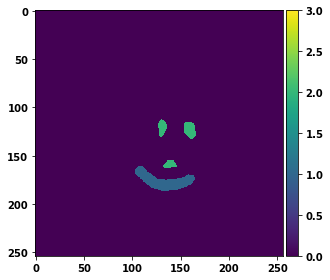

In [3]:
manual_annotations = labels

from skimage.io import imshow
imshow(manual_annotations, vmin=0, vmax=3)

We now convert the input data into an artificial 2-channel data:

Image data dimensions:  (2, 254, 256)


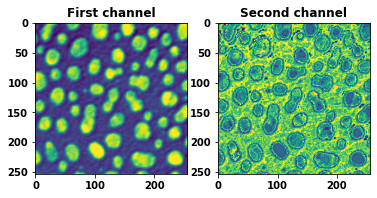

In [4]:
channel_1 = image
channel_2 = (1 - image)**2

fig, axes = plt.subplots(ncols=2)
axes[0].imshow(channel_1)
axes[0].set_title('First channel')
axes[1].imshow(channel_2)
axes[1].set_title('Second channel')

multi_channel_image = np.stack([channel_1, channel_2])
print('Image data dimensions: ', multi_channel_image.shape)

## Training
We now train a PixelClassifier, which is under the hood a [scikit-learn RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). After training, the classifier will be converted to [clij-compatible OpenCL code](https://github.com/clEsperanto/clij-opencl-kernels) and save to disk under a given filename.

In [5]:
# define features: original image, a blurred version and an edge image
features = "original gaussian_blur=2 sobel_of_gaussian_blur=2"

# this is where the model will be saved
cl_filename = 'my_model.cl'

apoc.erase_classifier(cl_filename)
clf = apoc.PixelClassifier(opencl_filename=cl_filename)
clf.train(features, manual_annotations, multi_channel_image)

## Prediction
The classifier can then be used to classify all pixels in the given image. Starting point is again, the feature stack. Thus, the user must make sure that the same features are used for training and for prediction.

C:\Users\johan\anaconda3\envs\apoc\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


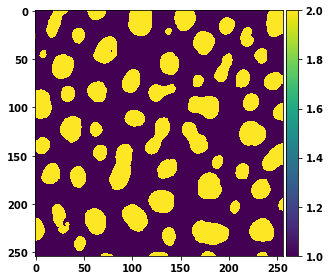

In [6]:
result = clf.predict(image=multi_channel_image)
imshow(result)

If we pass the data to the `clf.predict()` function in a wrong format - for instance, by passing single-channel data to a classifier that was trained on multi-channel data - we receive an error:

In [7]:
results = clf.predict(image = channel_1)

ValueError: Expected number of dimensions of input image to be 2, got 1

To avoid this issue, we can use the `clf.info()` function to see which dimensions the classifer expects for the prediction. 

*Note*: For the classifier to work on new data, **only the first dimension** needs to match. In other words:

* A classifer trained on a `[2, 256, 256]` image will work for new data with dimensions `[2, 512, 512]`
* A classifer trained on a `[2, 256, 256]` image will **not** work for new data with dimensions `[1, 256, 256]`

In [8]:
clf.info()

Classifier type: PixelClassifier
--- Random forest info ---
Used features for training: original gaussian_blur=2 sobel_of_gaussian_blur=2
Training data dimensions: [2 x X x Y]
Maximum depth: 2
Number of ensembles: 100
Number of classes:  2
